# Pipeline de Preprocesamiento de Datos de Rasgos Cuantitativos de Arroz

**Objetivo:** Realizar un análisis exploratorio de datos (EDA) robusto y preparar los datos de rasgos fenotípicos de arroz para análisis posteriores.

**Autor:** [Tu nombre]  
**Fecha:** Octubre 2025  
**Dataset:** Rasgos cuantitativos de arroz (2,266 accesiones × 12 rasgos)

---

## Índice
1. Configuración e Importación de Librerías
2. Carga de Datos
3. Exploración Inicial
4. Limpieza de Datos
5. Tratamiento de Valores Faltantes
6. Enriquecimiento con Metadatos
7. Alineación con Datos Genómicos
8. Exportación de Resultados

## 1. Configuración e Importación de Librerías

Configuración del entorno de trabajo e importación de las librerías necesarias para el análisis.

In [3]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# Manipulación de datos
import pandas as pd
import numpy as np
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Geolocalización
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pycountry

# Utilidades
import json
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN DE VISUALIZACIÓN
# ============================================================================

# Configuración de pandas
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
pd.set_option("display.precision", 2)

# Configuración de seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

# Configuración de matplotlib
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 100,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16
})

print("✓ Librerías importadas correctamente")
print(f"✓ Pandas versión: {pd.__version__}")
print(f"✓ NumPy versión: {np.__version__}")

ModuleNotFoundError: No module named 'geopy'

## 2. Carga de Datos

Carga del dataset de rasgos cuantitativos y configuración de rutas de trabajo.

In [3]:
# ============================================================================
# DEFINICIÓN DE RUTAS
# ============================================================================

ROOT = Path("..")
DATA_DIR = ROOT / "data"
TRAITS_PATH = DATA_DIR / "trait_data" / "quantitative_traits.csv"
REPORTS_DIR = ROOT / "reports"

# Crear directorios si no existen
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CARGA DE DATOS
# ============================================================================

df = pd.read_csv(TRAITS_PATH, index_col=0)

# Limpieza inicial de nombres de columnas y tipos de datos
df.columns = df.columns.str.strip()
df = df.apply(pd.to_numeric, errors="coerce")
df.index = df.index.astype(str).str.strip()

print(f"✓ Dataset cargado exitosamente")
print(f"  Dimensiones: {df.shape[0]:,} muestras × {df.shape[1]} rasgos")
print(f"  Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Dataset cargado exitosamente
  Dimensiones: 2,266 muestras × 12 rasgos
  Memoria utilizada: 0.34 MB


## 3. Exploración Inicial

### 3.1 Descripción de Rasgos

El dataset contiene 12 rasgos cuantitativos de arroz:

| Código | Descripción en Inglés | Descripción en Español | Unidad |
|--------|----------------------|------------------------|--------|
| **CUDI_REPRO** | Culm diameter | Diámetro del tallo | mm |
| **CULT_REPRO** | Culm length | Longitud del tallo | cm |
| **CUNO_REPRO** | Culm number | Número de tallos | unidades |
| **GRLT** | Grain length | Longitud del grano | mm |
| **GRWD** | Grain width | Ancho del grano | mm |
| **GRWT100** | 100-grain weight | Peso de 100 granos | g |
| **HDG_80HEAD** | Heading date (80% flowering) | Fecha de floración (80%) | días |
| **LIGLT** | Ligule length | Longitud de la lígula | mm |
| **LLT** | Leaf length | Longitud de la hoja | cm |
| **LWD** | Leaf width | Ancho de la hoja | cm |
| **PLT_POST** | Panicle length | Longitud de la panícula | cm |
| **SDHT** | Seedling height | Altura de plántula | cm |

In [4]:
# ============================================================================
# RESUMEN ESTADÍSTICO
# ============================================================================

print("=" * 80)
print("RESUMEN DEL DATASET")
print("=" * 80)

print(f"\n📊 Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas\n")

print("Columnas del dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "=" * 80)
print("PRIMERAS 5 MUESTRAS")
print("=" * 80)
display(df.head())

print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
display(df.describe().T)

RESUMEN DEL DATASET

📊 Dimensiones: 2,266 filas × 12 columnas

Columnas del dataset:
   1. CUDI_REPRO
   2. CULT_REPRO
   3. CUNO_REPRO
   4. GRLT
   5. GRWD
   6. GRWT100
   7. HDG_80HEAD
   8. LIGLT
   9. LLT
  10. LWD
  11. PLT_POST
  12. SDHT

PRIMERAS 5 MUESTRAS


,CUDI_REPRO,CULT_REPRO,CUNO_REPRO,GRLT,GRWD,GRWT100,HDG_80HEAD,LIGLT,LLT,LWD,PLT_POST,SDHT
IRIS_313.8783,5.0,147.0,16.0,8.7,3.1,2.9,102.0,25.0,72.0,1.1,29.0,54.0
IRIS_313.12081,NaN,NaN,NaN,6.7,2.6,2.6,122.0,NaN,NaN,NaN,NaN,NaN
IRIS_313.11422,NaN,NaN,NaN,7.9,2.9,2.5,97.0,NaN,NaN,NaN,NaN,NaN
IRIS_313.11821,6.0,150.0,27.0,7.1,3.3,2.1,123.0,20.0,73.0,1.5,27.0,45.0
IRIS_313.10565,5.0,144.0,20.0,9.8,2.9,2.8,118.0,15.0,65.0,1.5,32.0,27.0



ESTADÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
CUDI_REPRO,1899.0,4.87,1.00,2.0,4.00,5.0,5.0,9.1
CULT_REPRO,1900.0,113.81,29.53,27.0,94.00,117.0,136.0,204.0
CUNO_REPRO,1901.0,16.45,5.23,5.0,13.00,16.0,20.0,40.0
GRLT,2261.0,8.62,1.02,4.7,8.00,8.6,9.3,12.7
GRWD,2261.0,3.02,0.41,1.5,2.70,3.0,3.3,4.4
GRWT100,2259.0,2.49,0.52,1.0,2.20,2.5,2.8,5.0
HDG_80HEAD,2265.0,102.10,24.52,50.0,83.00,99.0,117.0,184.0
LIGLT,1878.0,18.46,5.62,4.0,15.00,18.0,22.0,47.0
LLT,1901.0,54.91,12.26,13.0,47.00,55.8,63.0,93.0
LWD,1901.0,1.38,0.32,0.4,1.10,1.3,1.6,2.5


### 3.2 Análisis de Valores Faltantes

ANÁLISIS DE VALORES FALTANTES POR RASGO

Rasgo           Faltantes    Porcentaje
---------------------------------------------
SDHT            389           17.17%
LIGLT           388           17.12%
PLT_POST        370           16.33%
CUDI_REPRO      367           16.20%
CULT_REPRO      366           16.15%
CUNO_REPRO      365           16.11%
LLT             365           16.11%
LWD             365           16.11%
GRWT100         7              0.31%
GRLT            5              0.22%
GRWD            5              0.22%
HDG_80HEAD      1              0.04%

DISTRIBUCIÓN DE VALORES FALTANTES POR MUESTRA

Muestras sin valores faltantes: 1,865 (82.3%)
Muestras con 1-3 faltantes: 32
Muestras con 4-6 faltantes: 5
Muestras con >6 faltantes: 364


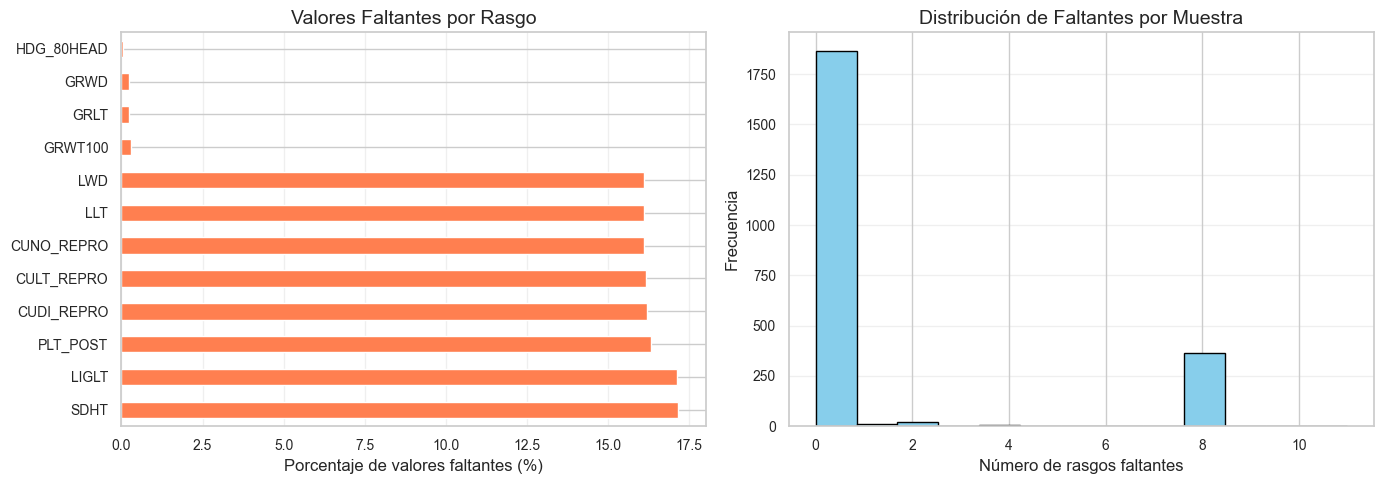


✓ Gráfico guardado en: ..\reports\missing_values_analysis.png


In [5]:
# ============================================================================
# ANÁLISIS DE VALORES FALTANTES
# ============================================================================

# Calcular porcentaje de valores faltantes por rasgo
missing_traits = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)

print("=" * 80)
print("ANÁLISIS DE VALORES FALTANTES POR RASGO")
print("=" * 80)

print(f"\n{'Rasgo':<15} {'Faltantes':<12} {'Porcentaje'}")
print("-" * 45)
for trait, pct in missing_traits.items():
    print(f"{trait:<15} {df[trait].isna().sum():<12} {pct:>6.2f}%")

# Calcular porcentaje de valores faltantes por muestra
missing_samples = df.isna().sum(axis=1)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE VALORES FALTANTES POR MUESTRA")
print("=" * 80)
print(f"\nMuestras sin valores faltantes: {(missing_samples == 0).sum():,} ({(missing_samples == 0).sum()/len(df)*100:.1f}%)")
print(f"Muestras con 1-3 faltantes: {((missing_samples > 0) & (missing_samples <= 3)).sum():,}")
print(f"Muestras con 4-6 faltantes: {((missing_samples > 3) & (missing_samples <= 6)).sum():,}")
print(f"Muestras con >6 faltantes: {(missing_samples > 6).sum():,}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras por rasgo
missing_traits.plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_xlabel('Porcentaje de valores faltantes (%)')
axes[0].set_title('Valores Faltantes por Rasgo')
axes[0].grid(axis='x', alpha=0.3)

# Histograma por muestra
axes[1].hist(missing_samples, bins=13, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Número de rasgos faltantes')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Faltantes por Muestra')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en: {REPORTS_DIR / 'missing_values_analysis.png'}")

## 4. Limpieza de Datos

### 4.1 Eliminación de Duplicados y Columnas Constantes

In [9]:
# ============================================================================
# LIMPIEZA: DUPLICADOS Y COLUMNAS CONSTANTES
# ============================================================================

print("=" * 80)
print("LIMPIEZA DE DATOS")
print("=" * 80)

# Verificar duplicados
duplicates = df.duplicated()
print(f"\n📌 Filas duplicadas encontradas: {duplicates.sum()}")

if duplicates.sum() > 0:
    print("   Eliminando duplicados...")
    df = df[~duplicates]

# Verificar columnas constantes
constant_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]
print(f"\n📌 Columnas constantes encontradas: {len(constant_cols)}")

if constant_cols:
    print(f"   Columnas: {constant_cols}")
    print("   Eliminando columnas constantes...")
    df = df.drop(columns=constant_cols)

print(f"\n✓ Dimensiones después de limpieza: {df.shape[0]:,} × {df.shape[1]}")

LIMPIEZA DE DATOS

📌 Filas duplicadas encontradas: 0

📌 Columnas constantes encontradas: 0

✓ Dimensiones después de limpieza: 1,902 × 12


## 5. Tratamiento de Valores Faltantes

### 5.1 Filtrado por Umbrales

Aplicamos umbrales de calidad para eliminar rasgos y muestras con exceso de valores faltantes:
- **Rasgos:** Eliminar si >20% de valores faltantes
- **Muestras:** Eliminar fila si hay  valore faltante

In [1]:
# ============================================================================
# FILTRADO POR UMBRALES DE VALORES FALTANTES
# ============================================================================

print("=" * 80)
print("FILTRADO POR UMBRALES")
print("=" * 80)

# Umbrales
TRAIT_THRESHOLD = 0.20  # 20% máximo de faltantes por rasgo
SAMPLE_THRESHOLD = 0.50  # 50% máximo de faltantes por muestra

original_shape = df.shape

# 1. Filtrar rasgos
trait_missing_pct = df.isna().mean()
traits_to_keep = trait_missing_pct[trait_missing_pct <= TRAIT_THRESHOLD].index
traits_removed = df.columns.difference(traits_to_keep)

print(f"\n1️⃣ FILTRADO DE RASGOS (umbral: {TRAIT_THRESHOLD*100:.0f}%)")
print(f"   Rasgos originales: {df.shape[1]}")
print(f"   Rasgos eliminados: {len(traits_removed)}")
if len(traits_removed) > 0:
    for trait in traits_removed:
        pct = trait_missing_pct[trait] * 100
        print(f"     - {trait}: {pct:.1f}% faltantes")

df = df[traits_to_keep]

# 2. Filtrar muestras
sample_missing_pct = df.isna().mean(axis=1)
samples_to_keep = df.dropna(inplace=True)
samples_removed = len(df) - len(samples_to_keep)

print(f"\n2️⃣ FILTRADO DE MUESTRAS (umbral: {SAMPLE_THRESHOLD*100:.0f}%)")
print(f"   Muestras originales: {original_shape[0]:,}")
print(f"   Muestras eliminadas: {samples_removed:,}")

df = df.loc[samples_to_keep]

print(f"\n✓ Dimensiones después del filtrado: {df.shape[0]:,} × {df.shape[1]}")
print(f"  Reducción: {(1 - df.shape[0]/original_shape[0])*100:.1f}% en muestras")

FILTRADO POR UMBRALES


NameError: name 'df' is not defined

## 8. Enriquecimiento con Metadatos

### 8.1 Carga de Metadatos Geográficos

In [ ]:
# ============================================================================
# CARGA DE METADATOS DE PAIS Y REGION
# ============================================================================

print("=" * 80)
print("ENRIQUECIMIENTO CON METADATOS")
print("=" * 80)
# Cargar metadata 3K Rice (país y región de origen)
# NOTA: Ajustar la ruta según tu estructura de archivos
metadata_path = "C:\\Users\\evalo\\OneDrive\\Escritorio\\PhD\\actividades\\Bootcamp\\Modulo1\\entrega1\\data\\3k_rice_table_complete.csv"  # Ajustar ruta

try:
    metadata = pd.read_csv(metadata_path)
    metadata['country'] = metadata['country'].replace(['na', 'Na', 'NA', 'n/a', 'N/A', 'none', 'None'], pd.NA)

    # Limpiar y mapear códigos (reemplazar - por .)
    metadata['code'] = metadata['code'].str.replace('-', '.', regex=False)
    
    # Crear diccionarios code -> country y code -> region
    code_to_country = dict(zip(metadata['code'], metadata['country']))
    code_to_region = dict(zip(metadata['code'], metadata['region']))
    code_to_subespecie = dict(zip(metadata['code'], metadata['SNP-based subspecies']))

    df_clean = df.copy()
    # Mapear país y región a cada accesión
    df_clean['country'] = df_clean.index.map(code_to_country)
    df_clean['region'] = df_clean.index.map(code_to_region)
    df_clean['subespecie'] = df_clean.index.map(code_to_subespecie)
    print(f"✓ Metadata cargada: {len(metadata)} accesiones")
    print(f"✓ Países mapeados: {df_clean['country'].notna().sum()} / {len(df_clean)} accesiones")
    print(f"✓ Regiones mapeadas: {df_clean['region'].notna().sum()} / {len(df_clean)} accesiones")
    print(f"✓ Subespecies mapeadas: {df_clean['subespecie'].notna().sum()} / {len(df_clean)} accesiones")
    
    print(f"\n🌍 Países representados: {df_clean['country'].nunique()}")
    print(f"🗺️ Regiones representadas: {df_clean['region'].nunique()}")
    print(f"🌱 Subespecies representadas: {df_clean['subespecie'].nunique()}")
    
    print(f"\nTop 10 países por número de accesiones:")
    print(df_clean['country'].value_counts().head(10))
    
    print(f"\nDistribución por región:")
    print(df_clean['region'].value_counts())

    print(f"\nDistribución por subespecie:")
    print(df_clean['subespecie'].value_counts())
    
    # Mostrar tabla cruzada región-país (primeras filas)
    if df_clean['region'].notna().any() and df_clean['country'].notna().any():
        print(f"\n📊 Tabla cruzada Región × País (top países):")
        crosstab = pd.crosstab(df_clean['region'], df_clean['country'], margins=True)
        # Mostrar solo las columnas de países más frecuentes + Total
        top_countries = df_clean['country'].value_counts().head(8).index.tolist()
        cols_to_show = top_countries + ['All']
        available_cols = [col for col in cols_to_show if col in crosstab.columns]
        print(crosstab[available_cols])
    
except FileNotFoundError:
    print("⚠️  Archivo de metadata no encontrado.")
    print("   Crea columnas 'country' y 'region' manualmente o ajusta la ruta.")
    df_clean['country'] = 'Unknown'  # Placeholder
    df_clean['region'] = 'Unknown'   # Placeholder
    df_clean['subespecie'] = 'Unknown'  # Placeholder

# Filtrar df_clean para quedarnos con las muestras con todos los metadatos
print(f"\n📋 Antes del filtro: {len(df_clean)} muestras")

# Contar muestras con metadatos completos
complete_metadata = df_clean['country'].notna() & df_clean['region'].notna()
print(f"✓ Muestras con metadata completo (country + region): {complete_metadata.sum()}")

# Opción 1: Filtrar solo las que tienen ambos metadatos
df_clean_complete = df_clean[complete_metadata].copy()

# Opción 2: Mantener todas, pero marcar las incompletas
df_clean['metadata_complete'] = complete_metadata

print(f"\n📊 Resumen final:")
print(f"   Total muestras: {len(df_clean)}")
print(f"   Con country y region: {complete_metadata.sum()}")
print(f"   Solo con country: {(df_clean['country'].notna() & df_clean['region'].isna()).sum()}")
print(f"   Sin metadatos: {(df_clean['country'].isna() & df_clean['region'].isna()).sum()}")

# Decidir qué versión usar para análisis posteriores
# Puedes cambiar esto según tus necesidades
if complete_metadata.sum() > 0:
    print(f"\n✓ Usando {len(df_clean_complete)} muestras con metadatos completos para análisis.")
    df_clean_complete.dropna(inplace=True)

    df_clean = df_clean_complete
else:
    print(f"\n⚠️ Manteniendo todas las {len(df_clean)} muestras (algunas sin metadatos completos).")

# ============================================================================
df_clean['HDG_category'] = pd.cut(
    df_clean['HDG_80HEAD'],
    bins=[-np.inf, 90, 110, np.inf],
    labels=['Early', 'Medium', 'Late']
)


ENRIQUECIMIENTO CON METADATOS
✓ Metadata cargada: 3010 accesiones
✓ Países mapeados: 1882 / 1902 accesiones
✓ Regiones mapeadas: 1894 / 1902 accesiones
✓ Subespecies mapeadas: 1894 / 1902 accesiones

🌍 Países representados: 82
🗺️ Regiones representadas: 10
🌱 Subespecies representadas: 5

Top 10 países por número de accesiones:
country
India          378
Indonesia      215
Bangladesh     173
China          171
Philippines    141
Thailand       107
Myanmar         59
Malaysia        48
Sri_Lanka       42
Madagascar      40
Name: count, dtype: int64

Distribución por región:
region
SAS    666
SEA    664
EAS    260
AFR    154
AME    104
EUR     23
na      12
WAS      4
OCE      4
WEU      3
Name: count, dtype: int64

Distribución por subespecie:
subespecie
IND    1117
JAP     440
AUS     201
ARO      71
ADM      65
Name: count, dtype: int64

📊 Tabla cruzada Región × País (top países):
country  India  Indonesia  Bangladesh  China  Philippines  Thailand  Myanmar  Malaysia   All
region       

### 8.2 Geocodificación de Países

**Nota:** Esta sección requiere conexión a internet y puede tardar varios minutos.

In [13]:


def get_coordinates(country_name, geolocator):
    """Obtiene las coordenadas del centroide de un país"""
    try:
        # Intentar primero con el nombre original
        location = geolocator.geocode(country_name, timeout=10)
        if location is None:
            # Si falla, intentar reemplazando guiones bajos por espacios
            location = geolocator.geocode(country_name.replace('_', ' '), timeout=10)
        
        if location:
            return location.latitude, location.longitude
        return None, None
    except Exception as e:
        print(f"Error obteniendo coordenadas para {country_name}: {str(e)}")
        return None, None
def normalize_country(name):
    try:
        return pycountry.countries.lookup(name).name
    except LookupError:
        return name
# Inicializar geocoder
geolocator = Nominatim(user_agent="rice_analysis_2025")

# Diccionario de coordenadas conocidas para casos especiales


# Obtener coordenadas para cada país único
countries = df_clean['country'].dropna().unique()
normalized_countries = [normalize_country(c) for c in countries]
coordinates_map = {}

print("Obteniendo coordenadas de países...")
for country in countries:


    lat, lon = get_coordinates(country, geolocator)
    if lat and lon:
        coordinates_map[country] = [lat, lon]
        print(f"✓ {country}: {lat:.2f}°, {lon:.2f}°")
    else:
        print(f"✗ {country}: No se encontraron coordenadas")
    time.sleep(1)  # Esperar entre peticiones

# Guardar coordenadas en archivo JSON
output_path = Path('../data/country_coordinates.json')
output_path.parent.mkdir(exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(coordinates_map, f, indent=4, ensure_ascii=False)

print(f"\n✓ Coordenadas guardadas en {output_path}")

# Añadir coordenadas al DataFrame
df_clean['latitude'] = df_clean['country'].map(lambda x: coordinates_map[x][0] if x in coordinates_map else None)
df_clean['longitude'] = df_clean['country'].map(lambda x: coordinates_map[x][1] if x in coordinates_map else None)

# Mostrar resumen de coordenadas
print("\nResumen de coordenadas:")
print(f"Países con coordenadas: {len(coordinates_map)}")
print(f"Accesiones con coordenadas: {df_clean['latitude'].notna().sum()} de {len(df_clean)}")

# Verificar cobertura
missing_coords = df_clean[df_clean['latitude'].isna()]['country'].unique()
if len(missing_coords) > 0:
    print("\nPaíses sin coordenadas:")
    for country in missing_coords:
        print(f"- {country}")

Obteniendo coordenadas de países...
✓ Sri_Lanka: 7.56°, 80.71°
✓ India: 22.35°, 78.67°
✓ Indonesia: -2.48°, 117.89°
✓ Japan: 36.57°, 139.24°
✓ Pakistan: 30.33°, 71.25°
✓ China: 35.00°, 105.00°
✓ Thailand: 14.90°, 100.83°
✓ France: 46.60°, 1.89°
✓ Liberia: 5.75°, -9.37°
✓ Bhutan: 27.55°, 90.51°
✓ Myanmar: 17.18°, 96.00°
✓ Senegal: 14.48°, -14.45°
✓ Soviet_Union: 44.57°, 27.36°
✓ Philippines: 12.75°, 122.73°
✓ Nicaragua: 12.35°, -85.78°
✓ Cambodia: 12.54°, 104.81°
✓ Hungary: 47.18°, 19.51°
✓ Africa: 11.50°, 17.76°
✓ Madagascar: -18.92°, 46.44°
✓ Cuba: 23.01°, -80.83°
✓ Nepal: 28.38°, 84.00°
✓ Malaysia: 4.57°, 102.27°
✓ Venezuela: 8.00°, -66.11°
✓ Kenya: 1.44°, 38.43°
✓ Bangladesh: 24.48°, 90.29°
✓ Gambia: 13.47°, -15.49°
✓ United_States: 39.78°, -100.45°
✓ Laos: 20.02°, 103.38°
✓ Brunei_Darussalam: 4.41°, 114.57°
✓ Sierra_Leone: 8.64°, -11.84°
✓ South_Korea: 36.64°, 127.70°
✓ Mexico: 23.66°, -102.01°
✓ Vietnam: 15.93°, 107.97°
✓ Peru: -6.87°, -75.05°
✓ Afghanistan: 33.77°, 66.24°
✓ Austr

## 9. Alineación con Datos Genómicos

Alineación de muestras entre datos fenotípicos y genómicos para análisis integrados.

In [17]:
# ============================================================================
# ALINEACIÓN CON DATOS GENÓMICOS
# ============================================================================

print("=" * 80)
print("ALINEACIÓN CON DATOS GENÓMICOS")
print("=" * 80)

GENO_PATH = DATA_DIR / "genotype_data" / "12k_ld_imputed.csv"
try:
    # Cargar datos genómicos
    geno = pd.read_csv(GENO_PATH, index_col=0)
    geno.index = geno.index.astype(str).str.strip()
    
    print(f"\n✓ Datos genómicos cargados: {geno.shape[0]:,} × {geno.shape[1]:,} SNPs")
    
    # Identificar muestras comunes
    traits_ids = set(df_clean.index)
    geno_ids = set(geno.index)
    common_ids = traits_ids.intersection(geno_ids)
    
    print(f"\nAnálisis de superposición:")
    print(f"  Muestras en rasgos: {len(traits_ids):,}")
    print(f"  Muestras en genotipos: {len(geno_ids):,}")
    print(f"  Muestras en común: {len(common_ids):,}")
    print(f"  Solo en rasgos: {len(traits_ids - geno_ids):,}")
    print(f"  Solo en genotipos: {len(geno_ids - traits_ids):,}")
    
    if len(common_ids) == 0:
        print("\n⚠ ERROR: No hay muestras en común")
        print("  Verificar formato de IDs de muestra")
    else:
        # Crear subconjuntos alineados
        common_ids_sorted = sorted(common_ids)
        traits_aligned = df_clean.loc[common_ids_sorted].copy()
        geno_aligned = geno.loc[common_ids_sorted].copy()
        
        print(f"\n✓ Alineación exitosa:")
        print(f"  Rasgos alineados: {traits_aligned.shape}")
        print(f"  Genotipos alineados: {geno_aligned.shape}")
        
        # Guardar datasets alineados
        traits_aligned.to_csv(REPORTS_DIR / "traits_aligned.csv")
        geno_aligned.to_csv(REPORTS_DIR / "genotypes_aligned.csv")
        
        print(f"\n✓ Datasets alineados guardados en {REPORTS_DIR}")

except FileNotFoundError:
    print(f"\n⚠ Archivo de genotipos no encontrado: {GENO_PATH}")
    print("  Omitiendo alineación genómica...")
except Exception as e:
    print(f"\n⚠ Error durante alineación: {str(e)}")

ALINEACIÓN CON DATOS GENÓMICOS

✓ Datos genómicos cargados: 3,023 × 12,486 SNPs

Análisis de superposición:
  Muestras en rasgos: 1,882
  Muestras en genotipos: 3,023
  Muestras en común: 1,882
  Solo en rasgos: 0
  Solo en genotipos: 1,141

✓ Alineación exitosa:
  Rasgos alineados: (1882, 17)
  Genotipos alineados: (1882, 12486)

✓ Datasets alineados guardados en ..\reports


## 10. Exportación de Resultados

Guardado de todos los datasets procesados y reporte de resumen.

In [ ]:
# ============================================================================
# EXPORTACIÓN DE RESULTADOS
# ============================================================================

print("=" * 80)
print("EXPORTACIÓN DE RESULTADOS")
print("=" * 80)

# Crear diccionario de datasets
datasets = {
    'traits_clean': df_clean,
}

# Guardar datasets
print("\nGuardando datasets procesados...")
for name, dataset in datasets.items():
    output_path = REPORTS_DIR / f"{name}.csv"
    dataset.to_csv(output_path)
    print(f"  ✓ {name}.csv - {dataset.shape[0]:,} × {dataset.shape[1]} columnas")






print("\n" + "=" * 80)
print("✓ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 80)
print(f"\nTodos los archivos guardados en: {REPORTS_DIR.absolute()}")

EXPORTACIÓN DE RESULTADOS

Guardando datasets procesados...
  ✓ traits_clean.csv - 1,882 × 17 columnas

RESUMEN DEL PREPROCESAMIENTO

✓ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE

Todos los archivos guardados en: c:\Users\evalo\OneDrive\Escritorio\PhD\actividades\Bootcamp\Modulo1\entrega3KRice\3KGenomeRice\notebook\..\reports


---

## Conclusiones del Preprocesamiento

### Resultados Clave:

1. **Calidad de datos mejorada:** Se eliminaron duplicados, valores constantes y muestras/rasgos con exceso de faltantes
2. **Imputación robusta:** Uso de mediana para resistencia ante outliers
3. **Enriquecimiento:** Metadatos de pasaporte integrados
4. **Alineación genómica:** Muestras sincronizadas con datos moleculares

### Archivos Generados:

- `traits_raw.csv` - Datos originales limpios
- `traits_clean.csv` - Datos imputados con metadatos
- `traits_aligned.csv` - Rasgos alineados con genotipos
- `genotypes_aligned.csv` - Genotipos alineados
- `preprocessing_summary.json` - Reporte detallado
- Gráficos: `missing_values_analysis.png`, `outliers_boxplots.png`, `standardization_comparison.png`


---

